In [13]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [26]:
# Load dataset
data = pd.read_csv('electric_toothbrush_timeseries.csv')
data

,Year,Revenue_USD_billion,Estimated_Units_million,Cumulative_Units_million
0,2010,1.751,35.02,35.02
1,2011,1.821,36.42,71.44
2,2012,1.894,37.88,109.32
3,2013,1.969,39.38,148.70
4,2014,2.048,40.96,189.66
5,2015,2.130,42.60,232.26
6,2016,2.237,44.74,277.00
7,2017,2.348,46.96,323.96
8,2018,2.466,49.32,373.28
9,2019,2.589,51.78,425.06


In [27]:
t = data['Year'] - data['Year'].min()
Y = data['Cumulative_Units_million'].values

In [28]:
## Step 4: Estimate Bass Model Parameters

# Define Bass cumulative function
def bass_cumulative(t, p, q, M):
    exp_term = np.exp(-(p+q)*t)
    return M * (1 - exp_term) / (1 + (q/p)*exp_term)

# Provide reasonable initial guesses
initial_guess = [0.03, 0.38, 1500]  # p, q, M

# Fit curve
params, covariance = curve_fit(bass_cumulative, t, Y, p0=initial_guess, bounds=([0,0,max(Y)],[1,1,3000]))
p, q, M = params

print(f"Estimated Bass Parameters:\np = {p:.4f}, q = {q:.4f}, M = {M:.2f} million units")

Estimated Bass Parameters:
p = 0.0113, q = 0.0894, M = 3000.00 million units


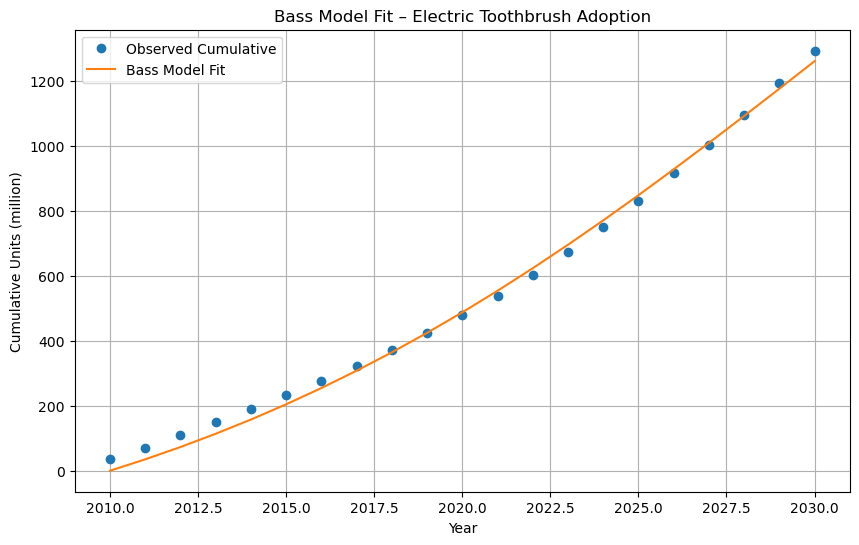

In [29]:
Fitted = bass_cumulative(t, p, q, M)

plt.figure(figsize=(10,6))
plt.plot(data['Year'], Y, 'o', label='Observed Cumulative')
plt.plot(data['Year'], Fitted, '-', label='Bass Model Fit')
plt.xlabel('Year')
plt.ylabel('Cumulative Units (million)')
plt.title('Bass Model Fit – Electric Toothbrush Adoption')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
## Step 5: Predict Diffusion Path

# Bass model formula for new adopters per period
def bass_adopters(t, p, q, M):
    F = (1 - np.exp(-(p+q)*t)) / (1 + (q/p)*np.exp(-(p+q)*t))
    return M * (F - np.roll(F, 1, axis=0))  # new adopters

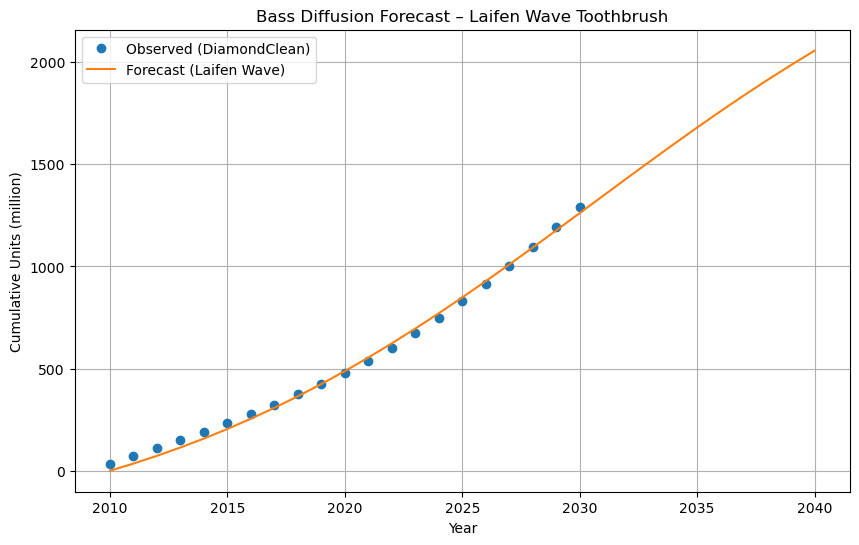

In [31]:
# Forecast
t_forecast = np.arange(0, 31)  # 2024-2054
F = (1 - np.exp(-(p+q)*t_forecast)) / (1 + (q/p)*np.exp(-(p+q)*t_forecast))
cumulative_forecast = M * F

plt.figure(figsize=(10,6))
plt.plot(data['Year'], data['Cumulative_Units_million'], 'o', label='Observed (DiamondClean)')
plt.plot(data['Year'].min() + t_forecast, cumulative_forecast, '-', label='Forecast (Laifen Wave)')
plt.xlabel('Year')
plt.ylabel('Cumulative Units (million)')
plt.title('Bass Diffusion Forecast – Laifen Wave Toothbrush')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
## Step 7: Estimate Number of Adopters by Year

new_adopters = M * (F - np.roll(F, 1))
new_adopters[0] = cumulative_forecast[0]

forecast_df = pd.DataFrame({
    'Year': data['Year'].min() + t_forecast,
    'New_Adopters_million': new_adopters,
    'Cumulative_Adopters_million': cumulative_forecast
})

forecast_df.head(10)

,Year,New_Adopters_million,Cumulative_Adopters_million
0,2010,0.000000,0.000000
1,2011,35.115309,35.115309
2,2012,37.888265,73.003574
3,2013,40.787951,113.791526
4,2014,43.802916,157.594442
5,2015,46.918073,204.512515
6,2016,50.114427,254.626942
7,2017,53.368897,307.995840
8,2018,56.654242,364.650082
9,2019,59.939139,424.589221


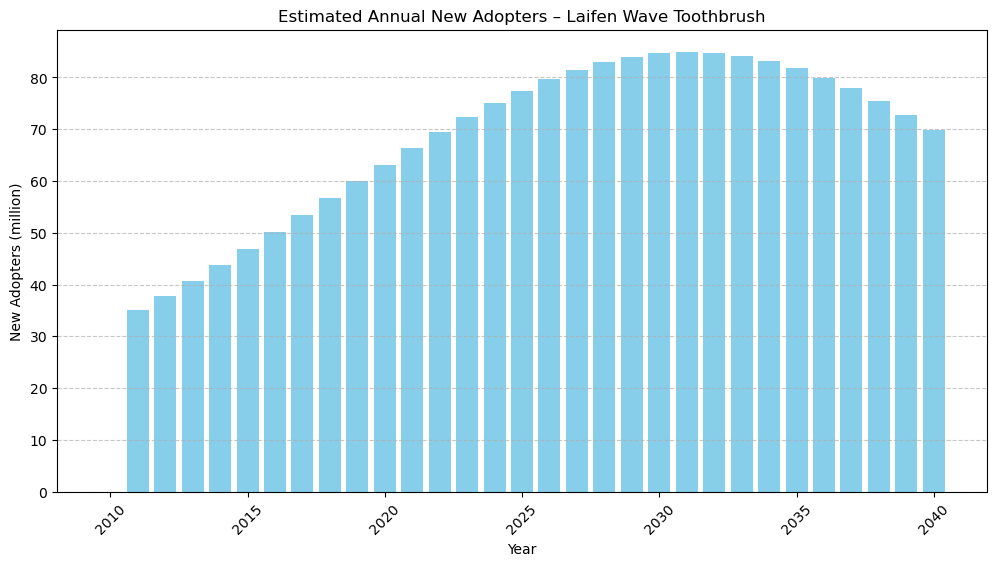

In [33]:
# Bar plot of new adopters per year
plt.figure(figsize=(12,6))
plt.bar(forecast_df['Year'], forecast_df['New_Adopters_million'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('New Adopters (million)')
plt.title('Estimated Annual New Adopters – Laifen Wave Toothbrush')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()